In [1]:
from keras import backend
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## import an image into the environment and reshape

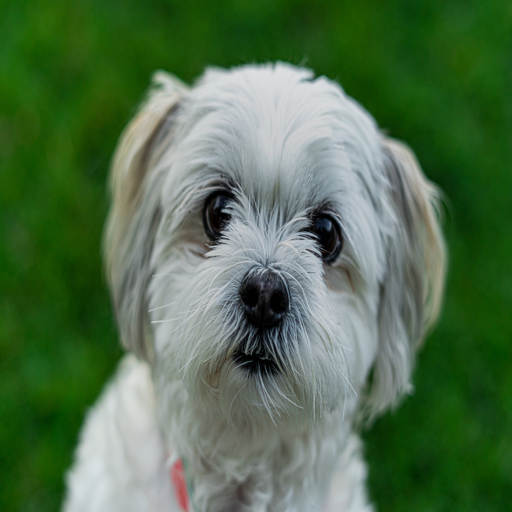

In [2]:
content_image = Image.open("content_image.jpeg").resize((512,512))
content_image

## import the style image into the environment and reshape

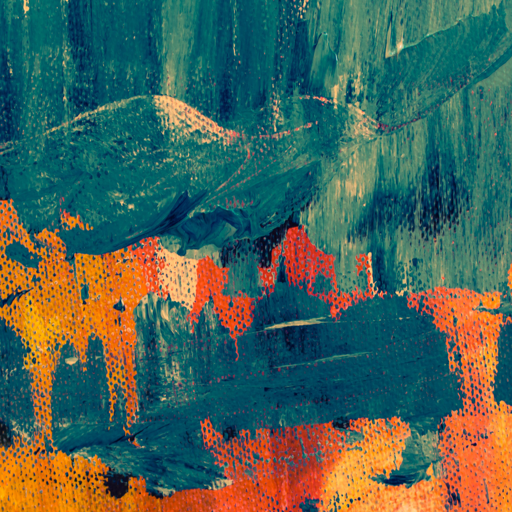

In [3]:
style_image = Image.open("style.png").resize((512,512))
style_image

## convert the images to numpy arrays for further processing

In [0]:
content_array = np.asarray(content_image, "float32")
content_array = np.expand_dims(content_array, axis = 0)

style_array = np.asarray(style_image, "float32")
style_array = np.expand_dims(style_array, axis = 0)

In [5]:
content_array.shape, style_array.shape

((1, 512, 512, 3), (1, 512, 512, 3))

### We added one extra dimension using the expand_dims function for concatenating these images into a tensor later, which will be the input to a VGG conv net model..

### Now according to the paper written for VGG we subtract the input images with the mean of the data which was calculated in the imagenet competition. This is available in google. 

### We do this to center the intensities of the image at zero to improve the accuracy and training speed. 

In [0]:
content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68

style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68


### We convert our RGB values to BGR to match the architecture of VGG16

In [0]:
content_array = content_array[:,:,:, ::-1]
style_array = style_array[:,:,:, ::-1]

### Now lets create our input tensor using keras backend(tensorflow graph). what is backend is explained really well here. check it out. http://keras.io/backend/

In [0]:
content_variable = backend.variable(content_array)
style_variable = backend.variable(style_array)

### Let's initialize a combination image variable using the backend placeholder function. 

In [9]:
combination_variable = backend.placeholder(shape = content_array.shape)

In [10]:
combination_variable.shape, style_variable.shape, content_variable.shape

(TensorShape([Dimension(1), Dimension(512), Dimension(512), Dimension(3)]),
 TensorShape([Dimension(1), Dimension(512), Dimension(512), Dimension(3)]),
 TensorShape([Dimension(1), Dimension(512), Dimension(512), Dimension(3)]))

### Using the concatenate function in backend we will concatenate these three variables which will return a tensor

In [0]:
tensor_variable = backend.concatenate([ content_variable, style_variable, combination_variable], axis = 0)

In [12]:
tensor_variable

<tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>

### Notice how we are concatenating on the first dimension? This way we preserve all the data we have so far. 

### As mentioned above we will be using a pre trained model called VGG16 which was initally developed as a classification problem

#### If you are not familiar with conv nets i will write another blog post explaining in detail what they mean and how they are useful. 

#### VGG 16 is a deep learning model with 16 layers and is a conv net classifier. Conv nets are believed to be able to percieve and "understand" images. But every conv net model have a few layers which perform a classification these are called fully connected layers or FC layers. We dont need these layers for our algorithm so we will choose only the ones we will need.  

### We can import the VGG16 model from keras applications 

In [0]:
from keras.applications.vgg16 import VGG16

In [14]:
vgg_model = VGG16(input_tensor = tensor_variable, weights = "imagenet", include_top = False)




58892288/58889256 [==============================] - 5s 0us/step








### include_top = False will ignore the fully connected layers and only retrieve the conv net layers.  

In [15]:
vgg_model.layers

In [16]:
layers  = dict([(layer.name, layer.output) for layer in vgg_model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

### Our model and our input is ready. We need to work on how to calculate loss. 

## Loss

#### Since the combination_image is a combination of both content and style images we need to calculate the loss respective to both these images. 

#### We choose the numbers based on the influence we want from each of these images in the combined image. 

In [0]:
content_weight = 0.025
style_weight = 2.5
total_variation_weight = 1

#### Initializing a tensor with 0 to store the loss

In [0]:
loss = backend.variable(0.)

### Content Loss

Calcuate loss between the combination image and the content image using the euclidean loss

Choosing the block2_conv2 layer for extracting  the content image features but we can choose others as well. 
Based on tensor we created before we can extract each of the features using the layers dict which contains block2_conv2 tensor.  

In [19]:
def calculate_content_loss(content, combination):
    return backend.sum(backend.square(content - combination))
    
layer_features = layers["block2_conv2"]
print(layer_features)
content_image_features = layer_features[0,:,:,:]
combination_image_features = layer_features[2,:,:,:]
print(content_image_features)

Tensor("block2_conv2/Relu:0", shape=(3, 256, 256, 128), dtype=float32)
Tensor("strided_slice:0", shape=(256, 256, 128), dtype=float32)


#### Finally calculating loss

In [0]:
loss = loss + (content_weight * calculate_content_loss(content_image_features, combination_image_features))

### Style Loss

#### Calculating style loss is a bit tricky but we will get through this. 

#### Calculate the gram matrix

In [0]:
def calculate_gram_matrix(matrix):
    features = backend.batch_flatten(backend.permute_dimensions(matrix, (2, 0, 1)))
    return backend.dot(features, backend.transpose(features))

In [0]:
def calculate_style_loss(style, combination):
    style_gram = calculate_gram_matrix(style)
    combination_gram = calculate_gram_matrix(combination)
    channels = 3
    size = 512 * 512 ## height * width
    return backend.sum(backend.square(style_gram - combination_gram)) / (4. * (channels **2) * (size ** 2))

feature_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

for i in feature_layers:
    layer_features = layers[i]
    style_image_features = layer_features[1,:,:,:]
    combination_image_features = layer_features[2,:,:,:]
    style_loss = calculate_style_loss(style_image_features, combination_image_features)
    loss = loss + (style_weight/ len(feature_layers))*style_loss

### Total Loss

In [0]:
def total_variation_loss(tensor):
    a = backend.square(tensor[:, :511, :511, :] - tensor[:, 1:, :511, :])
    b = backend.square(tensor[:, :511, :511, :] - tensor[:, :511, 1:, :])
    return backend.sum(backend.pow(a+b, 1.25))
loss= loss + total_variation_weight*total_variation_loss(combination_variable)

### Calculate gradients 

In [24]:
grads = backend.gradients(loss, combination_variable)

output = [loss]

if type(grads) in {tuple, list}:
    output+=grads
else:
    output.append(grads)
    
f_outputs = backend.function([combination_variable], output)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def eval_loss_and_grads(tensor):
    tensor = tensor.reshape((1, 512, 512, 3))
    outs = f_outputs([tensor])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values  = outs[1].flatten().astype("float64")
    else:
        grad_values  = np.array(outs[1:]).flatten().astype("float64")
    return loss_value, grad_values
class Evaluator:
    
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
        
    def loss(self ,x):
        assert self.loss_value is None
        self.loss_value, self.grad_values = eval_loss_and_grads(x)
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator = Evaluator()

In [0]:
import time
from scipy.optimize import fmin_l_bfgs_b

In [27]:
x = np.random.uniform(0, 255, (1, 512, 512, 3)) - 128.

iterations = 10

for i in range(iterations):
    print("iternation #", i)
    start = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime = evaluator.grads, maxfun = 30)
    print("current_loss", min_val)
    end = time.time()
    print("iteration completed in ", end - start)

iternation # 0
current_loss 51568222000.0
iteration completed in  13.28370213508606
iternation # 1
current_loss 35479310000.0
iteration completed in  6.420667409896851
iternation # 2
current_loss 32356985000.0
iteration completed in  6.582182884216309
iternation # 3
current_loss 31375094000.0
iteration completed in  6.586491823196411
iternation # 4
current_loss 30945370000.0
iteration completed in  6.5498340129852295
iternation # 5
current_loss 30701918000.0
iteration completed in  6.6690099239349365
iternation # 6
current_loss 30542283000.0
iteration completed in  6.608313083648682
iternation # 7
current_loss 30435610000.0
iteration completed in  6.655436277389526
iternation # 8
current_loss 30354510000.0
iteration completed in  6.657579660415649
iternation # 9
current_loss 30297285000.0
iteration completed in  6.677911758422852


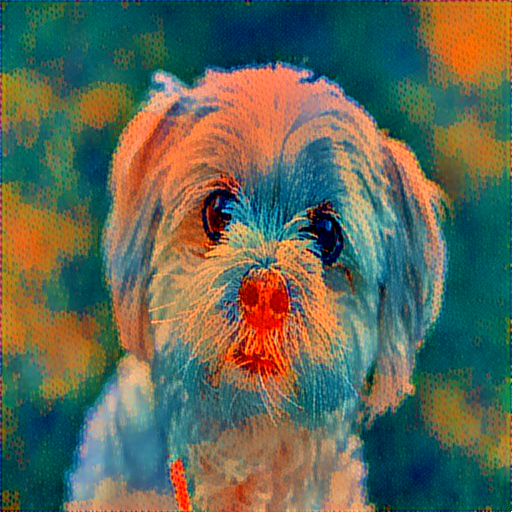

In [28]:
x = x.reshape((512,512,3))
x = x[:,:,::-1]
x[:,:,0]+=103.939
x[:,:,1]+= 116.779
x[:,:,2]+= 123.68
x = np.clip(x, 0, 255).astype("uint8")

Image.fromarray(x)